# Cross-validation for parameter tuning, model selection, and feature selection ([video #7](https://www.youtube.com/watch?v=6dbrR-WymjI&list=PL5-da3qGB5ICeMbQuqbbCOQWcS6OYBr5A&index=7))

Created by [Data School](http://www.dataschool.io/). Watch all 9 videos on [YouTube](https://www.youtube.com/playlist?list=PL5-da3qGB5ICeMbQuqbbCOQWcS6OYBr5A). Download the notebooks from [GitHub](https://github.com/justmarkham/scikit-learn-videos).

**Note:** This notebook uses Python 3.6 and scikit-learn 0.19.1. The original notebook (shown in the video) used Python 2.7 and scikit-learn 0.16, and can be downloaded from the [archive branch](https://github.com/justmarkham/scikit-learn-videos/tree/archive).

## Agenda

- What is the drawback of using the **train/test split** procedure for model evaluation?
- How does **K-fold cross-validation** overcome this limitation?
- How can cross-validation be used for selecting **tuning parameters**, choosing between **models**, and selecting **features**?
- What are some possible **improvements** to cross-validation?

## Review of model evaluation procedures

**Motivation:** Need a way to choose between machine learning models

- Goal is to estimate likely performance of a model on **out-of-sample data**

**Initial idea:** Train and test on the same data

- But, maximizing **training accuracy** rewards overly complex models which **overfit** the training data

**Alternative idea:** Train/test split

- Split the dataset into two pieces, so that the model can be trained and tested on **different data**
- **Testing accuracy** is a better estimate than training accuracy of out-of-sample performance
- But, it provides a **high variance** estimate since changing which observations happen to be in the testing set can significantly change testing accuracy

In [1]:

# implementation 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [2]:

data = sns.load_dataset('mpg')

y = data[["mpg"]]
X = data.drop(["mpg", "name", "origin"], axis=1)


In [3]:
# use train/test split with different random_state values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)


In [4]:
# calculate the mean horsepower for different levels of cylinders on the training data
X_train.groupby('cylinders')['horsepower'].mean()

cylinders
3     99.250000
4     78.441558
5     85.000000
6    102.301587
8    157.819444
Name: horsepower, dtype: float64

In [5]:
#use those means to impute any missing values
cyl_hp = X_train.groupby('cylinders')['horsepower'].mean().round(1).to_dict()
print(cyl_hp)

X_train['horsepower'].fillna(X_train['cylinders'].map(cyl_hp), inplace=True)
X_test['horsepower'].fillna(X_test['cylinders'].map(cyl_hp), inplace=True)

{3: 99.2, 4: 78.4, 5: 85.0, 6: 102.3, 8: 157.8}


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [6]:
# check classification accuracy of KNN with K=5
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
print(metrics.mean_squared_error(y_test, y_pred))

11.322146425041943


**Question:** What if we created a bunch of train/test splits, calculated the testing accuracy for each, and averaged the results together?

**Answer:** That's the essense of cross-validation!

## Steps for K-fold cross-validation

1. Split the dataset into K **equal** partitions (or "folds").
2. Use fold 1 as the **testing set** and the union of the other folds as the **training set**.
3. Calculate **testing accuracy**.
4. Repeat steps 2 and 3 K times, using a **different fold** as the testing set each time.
5. Use the **average testing accuracy** as the estimate of out-of-sample accuracy.

Diagram of **5-fold cross-validation:**

![5-fold cross-validation](images/07_cross_validation_diagram.png)

In [7]:
# simulate splitting a dataset of 25 observations into 5 folds
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=False).split(range(25))

# print the contents of each training and testing set
print('{} {:^61} {}'.format('Iteration', 'Training set observations', 'Testing set observations'))
for iteration, data in enumerate(kf, start=1):
    print('{:^9} {} {:^25}'.format(iteration, data[0], str(data[1])))

Iteration                   Training set observations                   Testing set observations
    1     [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]        [0 1 2 3 4]       
    2     [ 0  1  2  3  4 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]        [5 6 7 8 9]       
    3     [ 0  1  2  3  4  5  6  7  8  9 15 16 17 18 19 20 21 22 23 24]     [10 11 12 13 14]     
    4     [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 20 21 22 23 24]     [15 16 17 18 19]     
    5     [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]     [20 21 22 23 24]     


- Dataset contains **25 observations** (numbered 0 through 24)
- 5-fold cross-validation, thus it runs for **5 iterations**
- For each iteration, every observation is either in the training set or the testing set, **but not both**
- Every observation is in the testing set **exactly once**

## Comparing cross-validation to train/test split

Advantages of **cross-validation:**

- More accurate estimate of out-of-sample accuracy
- More "efficient" use of data (every observation is used for both training and testing)

Advantages of **train/test split:**

- Runs K times faster than K-fold cross-validation
- Simpler to examine the detailed results of the testing process

## Cross-validation recommendations

1. K can be any number, but **K=10** is generally recommended
2. For classification problems, **stratified sampling** is recommended for creating the folds
    - Each response class should be represented with equal proportions in each of the K folds
    - scikit-learn's `cross_val_score` function does this by default

## Cross-validation example: parameter tuning

**Goal:** Select the best tuning parameters (aka "hyperparameters") for KNN on the iris dataset

In [8]:
#use those means to impute any missing values
cyl_hp = X.groupby('cylinders')['horsepower'].mean().round(1).to_dict()
print(cyl_hp)

X['horsepower'].fillna(X['cylinders'].map(cyl_hp), inplace=True)


{3: 99.2, 4: 78.3, 5: 82.3, 6: 101.5, 8: 158.3}


In [9]:
from sklearn.model_selection import cross_val_score

In [10]:
# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
ridge = Ridge(alpha= 0.1)
scores = cross_val_score(ridge, X, y, cv=10, scoring='neg_mean_squared_error')
print(-scores)

[ 8.93742982 10.7329855  12.30951955  8.35275677  5.61140501  6.14088529
 18.82015866 11.6929166  37.11300007 16.71048419]


In [11]:
metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

https://scikit-learn.org/stable/modules/model_evaluation.html

In [12]:
# use average accuracy as an estimate of out-of-sample accuracy
print(-scores.mean())

13.64215414666468


In [13]:
# search for an optimal value of alpha for alpha ridge
alphas = [0.01, 0.1, 0.3, 0.5, 1]
a_scores = []
for a in alphas:
    ridge = Ridge(alpha=a)
    scores = cross_val_score(ridge, X, y, cv=10, scoring='neg_mean_squared_error')
    a_scores.append(-scores.mean())
print(a_scores)

[13.64224332982389, 13.64215414666468, 13.641956479206547, 13.641759521570847, 13.64127020316152]


## Improvements to cross-validation

**Repeated cross-validation**

- Repeat cross-validation multiple times (with **different random splits** of the data) and average the results
- More reliable estimate of out-of-sample performance by **reducing the variance** associated with a single trial of cross-validation

**Creating a hold-out set**

- "Hold out" a portion of the data **before** beginning the model building process
- Locate the best model using cross-validation on the remaining data, and test it **using the hold-out set**
- More reliable estimate of out-of-sample performance since hold-out set is **truly out-of-sample**

**Feature engineering and selection within cross-validation iterations**

- Normally, feature engineering and selection occurs **before** cross-validation
- Instead, perform all feature engineering and selection **within each cross-validation iteration**
- More reliable estimate of out-of-sample performance since it **better mimics** the application of the model to out-of-sample data

## Resources

- scikit-learn documentation: [Cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html), [Model evaluation](http://scikit-learn.org/stable/modules/model_evaluation.html)
- scikit-learn issue on GitHub: [MSE is negative when returned by cross_val_score](https://github.com/scikit-learn/scikit-learn/issues/2439)
- Section 5.1 of [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/) (11 pages) and related videos: [K-fold and leave-one-out cross-validation](https://www.youtube.com/watch?v=nZAM5OXrktY&list=PL5-da3qGB5IA6E6ZNXu7dp89_uv8yocmf) (14 minutes), [Cross-validation the right and wrong ways](https://www.youtube.com/watch?v=S06JpVoNaA0&list=PL5-da3qGB5IA6E6ZNXu7dp89_uv8yocmf) (10 minutes)
- Scott Fortmann-Roe: [Accurately Measuring Model Prediction Error](http://scott.fortmann-roe.com/docs/MeasuringError.html)
- Machine Learning Mastery: [An Introduction to Feature Selection](http://machinelearningmastery.com/an-introduction-to-feature-selection/)
- Harvard CS109: [Cross-Validation: The Right and Wrong Way](https://github.com/cs109/content/blob/master/lec_10_cross_val.ipynb)
- Journal of Cheminformatics: [Cross-validation pitfalls when selecting and assessing regression and classification models](http://www.jcheminf.com/content/pdf/1758-2946-6-10.pdf)

# Efficiently searching for optimal tuning parameters ([video #8](https://www.youtube.com/watch?v=Gol_qOgRqfA&list=PL5-da3qGB5ICeMbQuqbbCOQWcS6OYBr5A&index=8))

Created by [Data School](http://www.dataschool.io/). Watch all 9 videos on [YouTube](https://www.youtube.com/playlist?list=PL5-da3qGB5ICeMbQuqbbCOQWcS6OYBr5A). Download the notebooks from [GitHub](https://github.com/justmarkham/scikit-learn-videos).

**Note:** This notebook uses Python 3.6 and scikit-learn 0.19.1. The original notebook (shown in the video) used Python 2.7 and scikit-learn 0.16, and can be downloaded from the [archive branch](https://github.com/justmarkham/scikit-learn-videos/tree/archive).


## Agenda

- How can K-fold cross-validation be used to search for an **optimal tuning parameter**?
- How can this process be made **more efficient**?
- How do you search for **multiple tuning parameters** at once?
- What do you do with those tuning parameters before making **real predictions**?
- How can the **computational expense** of this process be reduced?


## More efficient parameter tuning using `GridSearchCV`

Allows you to define a **grid of parameters** that will be **searched** using K-fold cross-validation


In [14]:

from sklearn.model_selection import GridSearchCV

# define the parameter values that should be searched
alpha_range = [0.01, 0.05, 0.1, 0.5, 1, 5, 10]
print(alpha_range)


[0.01, 0.05, 0.1, 0.5, 1, 5, 10]


In [15]:

# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(alpha=alpha_range)
print(param_grid)


{'alpha': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}


In [16]:
ridge = Ridge()

In [17]:
# the higher you set verbose, the more feedback you will receive
# n_jobs = -1 will use all of your available hardware cores except for 1, limiting the other things that you can do on your computer but maximizing python speed
# instantiate the grid
grid = GridSearchCV(ridge, param_grid, cv=10, scoring='neg_mean_squared_error', verbose =1, return_train_score=False)



- You can set **`n_jobs = -1`** to run computations in parallel (if supported by your computer and OS)


In [18]:

# fit the grid with data
grid.fit(X, y)


Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.4s finished
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=1)

In [19]:
# view the results as a pandas DataFrame
# cv is cross validation
import pandas as pd
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,-13.575561,8.728057,{'alpha': 0.01}
1,-13.575522,8.728024,{'alpha': 0.05}
2,-13.575473,8.727984,{'alpha': 0.1}
3,-13.575081,8.727666,{'alpha': 0.5}
4,-13.574595,8.727277,{'alpha': 1}
5,-13.570855,8.724513,{'alpha': 5}
6,-13.566514,8.721849,{'alpha': 10}


In [20]:
# examine the first result
print(grid.cv_results_['params'][0])
print(grid.cv_results_['mean_test_score'][0])

{'alpha': 0.01}
-13.57556135032916


In [21]:
# print the array of mean scores only
grid_mean_scores = grid.cv_results_['mean_test_score']
print(grid_mean_scores)

[-13.57556135 -13.57552198 -13.5754728  -13.57508095 -13.57459501
 -13.5708549  -13.56651449]


Text(0, 0.5, 'Cross-Validated MSE')

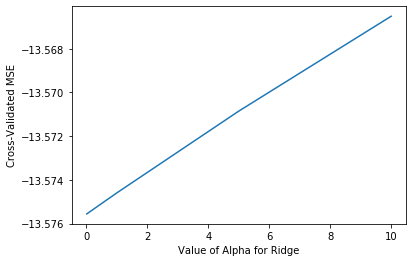

In [22]:
# plot the results
plt.plot(alpha_range, grid_mean_scores)
plt.xlabel('Value of Alpha for Ridge')
plt.ylabel('Cross-Validated MSE')

In [23]:
# examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)


-13.566514487899518
{'alpha': 10}
Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)


In [24]:
grid.best_estimator_.fit(X_train, y_train)

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)


## Searching multiple parameters simultaneously

- **Example:** tuning `max_depth` and `min_samples_leaf` for a `DecisionTreeClassifier`
- Could tune parameters **independently**: change `max_depth` while leaving `min_samples_leaf` at its default value, and vice versa
- But, best performance might be achieved when **neither parameter** is at its default value


In [25]:
# define the parameter values that should be searched
penalty = ['l1', 'l2']

In [26]:
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(alpha=alpha_range, norm=penalty)
print(param_grid)

{'alpha': [0.01, 0.05, 0.1, 0.5, 1, 5, 10], 'norm': ['l1', 'l2']}


## Reducing computational expense using `RandomizedSearchCV`

- Searching many different parameters at once may be computationally infeasible
- `RandomizedSearchCV` searches a subset of the parameters, and you control the computational "budget"


In [27]:
# ridge does not accept a penalty param
from sklearn.model_selection import RandomizedSearchCV

# specify "parameter distributions" rather than a "parameter grid"
param_dist = dict(n_neighbors=k_range, weights=weight_options)

NameError: name 'k_range' is not defined

- **Important:** Specify a continuous distribution (rather than a list of values) for any continous parameters


In [ ]:
# n_iter controls the number of searches
rand = RandomizedSearchCV(knn, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=5, return_train_score=False)
rand.fit(X, y)
pd.DataFrame(rand.cv_results_)[['mean_test_score', 'std_test_score', 'params']]


In [ ]:
# examine the best model
print(rand.best_score_)
print(rand.best_params_)


In [ ]:
# run RandomizedSearchCV 20 times (with n_iter=10) and record the best score
best_scores = []
for _ in range(20):
    rand = RandomizedSearchCV(knn, param_dist, cv=10, scoring='accuracy', n_iter=10, return_train_score=False)
    rand.fit(X, y)
    best_scores.append(round(rand.best_score_, 3))
print(best_scores)

## Resources

- scikit-learn documentation: [Grid search](http://scikit-learn.org/stable/modules/grid_search.html), [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
- Timed example: [Comparing randomized search and grid search](http://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html)
- scikit-learn workshop by Andreas Mueller: [Video segment on randomized search](https://youtu.be/0wUF_Ov8b0A?t=17m38s) (3 minutes), [related notebook](https://github.com/amueller/pydata-nyc-advanced-sklearn/blob/master/Chapter%203%20-%20Randomized%20Hyper%20Parameter%20Search.ipynb)
- Paper by Yoshua Bengio: [Random Search for Hyper-Parameter Optimization](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf)